In [2]:
# Importando bibliotecas

import numpy as np
import seaborn as sb
import pandas as pd
from statistics import median
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
# Importando dados

df = pd.read_csv('data_messy.csv')


In [4]:
# Printando nome das colunas
print(df.columns.tolist())

[' Campaign_ID ', 'Campaign_Name', 'Start_Date', 'End_Date', 'Channel', 'Impressions', 'Clicks ', 'Spend', 'Conversions', 'Active', 'Clicks', 'Campaign_Tag']


In [5]:
# Limpando títulos das colunas
df.columns = df.columns.str.strip().str.lower().str.replace(' ','_')

In [6]:
# Limpando coluna: de string para float

colunas_sujas = df['spend'].astype(str).str.contains(r'\$')
print(df.loc[colunas_sujas,['campaign_id','spend']].head(3))
df['spend'] = df['spend'].astype(str).str.replace(r'[^\d.-]','',regex=True).astype(float)

   campaign_id     spend
0    CMP-00001   $102.82
21   CMP-00022   $2428.4
22   CMP-00023  $4726.22


In [7]:
# Limpando listas

df['channel'].unique().tolist()

dicionario = {
    'Tik_Tok':'TikTok',
     'Facebok':'Facebook',
    'E-mail':'Email',
    'Insta_gram':'Instagram',
     'Gogle': 'Google Ads',
        'N/A':np.nan
}

df['channel'] = df['channel'].replace(dicionario)
df['channel'].unique().tolist()


['TikTok', 'Facebook', 'Email', 'Instagram', 'Google Ads', nan]

In [8]:
# Manuseando booleans

print(df['active'].unique())


boolean = {
    'Y': True,
    0: False,
    1: True,
    'No': False,
    'Yes': True,
    '1':True,
    '0': False,
    'True': True,
    'False': False

}

df['active'] = df['active'].map(boolean).fillna(False).astype(bool)
print(df['active'].unique())

<ArrowStringArray>
['Y', '0', 'No', 'True', 'Yes', '1', 'False']
Length: 7, dtype: str
[ True False]


In [9]:
# Convertendo para data os valores em string

df['start_date'] = pd.to_datetime(df['start_date'],errors='coerce',dayfirst=False)
df['end_date'] = pd.to_datetime(df['end_date'],errors='coerce',dayfirst=False)

print(df['end_date'].dtype)


datetime64[us]


In [10]:
# Removendo colunas duplicadas
df = df.loc[:, ~df.columns.duplicated()]


In [11]:
# Integridade Lógica
impossible_mask = df['clicks'] > df['impressions']
print(df.loc[impossible_mask,['campaign_id','impressions','clicks']].head(3))

Empty DataFrame
Columns: [campaign_id, impressions, clicks]
Index: []


In [12]:
# Evitando viagem no tempo
time_travel = df['end_date'] < df['start_date']
df.loc[time_travel,'end_date'] = df.loc[time_travel,'start_date'] + pd.Timedelta(days=30)
print(df.loc[time_travel,['campaign_id','start_date','end_date']].head(3))



   campaign_id start_date   end_date
23   CMP-00024 2023-05-06 2023-06-05
54   CMP-00055 2023-09-01 2023-10-01
71   CMP-00072 2023-02-01 2023-03-03


In [13]:
# Lidando com gastos negativos
negativo = df['spend'] < 0
print(df.loc[negativo,['spend','campaign_id']].head(3))
mediana= df.loc[df['spend'] >= 0,'spend'].median()
df.loc[negativo,'spend'] = mediana


       spend campaign_id
144 -1407.54   CMP-00145
407 -1214.52   CMP-00408
576  -821.80   CMP-00577


In [14]:
# Manuseando outliers

Q1 = df['spend'].quantile(0.25)
Q3 = df['spend'].quantile(0.75)
IQR = Q3 - Q1
upper_limite = Q3 + (1.5*IQR)

outlier_mask = df['spend'] > upper_limite
print(df.loc[outlier_mask,['spend','campaign_id']].head(3))

df.loc[outlier_mask,'spend']= upper_limite
print(df.loc[outlier_mask,['spend','campaign_id']].head(3))


       spend campaign_id
57   5719.84   CMP-00058
70   5951.42   CMP-00071
119  7471.52   CMP-00120
        spend campaign_id
57   5593.585   CMP-00058
70   5593.585   CMP-00071
119  5593.585   CMP-00120


<Axes: xlabel='conversions'>

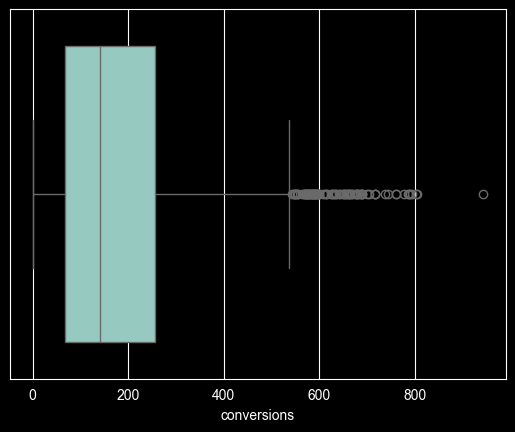

In [15]:
sb.boxplot(x=df['conversions'])

In [16]:
# Extraindo strings

df['season'] = df['campaign_name'].str.extract(r'Q\d_([^_]+)_')

df

,campaign_id,campaign_name,start_date,end_date,channel,impressions,clicks,spend,conversions,active,campaign_tag,season
0,CMP-00001,Q4_Summer_CMP-00001,2023-11-24,2023-12-13,TikTok,16795,197,102.82,20.0,True,TI,Summer
1,CMP-00002,Q1_Launch_CMP-00002,2023-05-06,2023-05-12,Facebook,1860,30,24.33,1.0,False,FA,Launch
2,CMP-00003,Q3_Winter_CMP-00003,2023-12-13,2023-12-20,Email,77820,843,1323.39,51.0,False,EM,Winter
3,CMP-00004,Q1_BlackFriday_CMP-00004,NaT,2023-11-03,TikTok,55886,2019,2180.38,135.0,True,TI,BlackFriday
4,CMP-00005,Q2_Winter_CMP-00005,2023-04-22,2023-04-23,Facebook,7265,169,252.44,30.0,True,FA,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...
2015,CMP-00400,Q3_Summer_CMP-00400,2023-10-31,2023-11-13,TikTok,30592,586,503.95,77.0,True,TI,Summer
2016,CMP-01255,Q4_Summer_CMP-01255,2023-09-01,2023-09-26,Google Ads,20097,897,1641.00,162.0,False,GO,Summer
2017,CMP-01050,Q2_Launch_CMP-01050,2023-02-09,2023-02-21,Instagram,33254,1117,883.82,214.0,False,IN,Launch
2018,CMP-01118,Q4_Winter_CMP-01118,2023-03-30,2023-04-27,Facebook,68728,2960,4198.50,591.0,True,FA,Winter


In [17]:
# Salvando em PDF
df.to_csv('publicidade.csv',index=False,header=True,sep= ';')

In [18]:
# Limpeza em outros atributos

df = df.dropna(subset=['conversions']).copy()
df['channel'] = df['channel'].fillna('unknown')
df['season'] = df['season'].fillna('unknown')

In [19]:
# Criação de novas colunas

df['duration_days'] = (df['end_date'] - df['start_date']).dt.days
df['duration_days'] = df['duration_days'].fillna(df['duration_days'].median())


In [20]:
# Dummização

features = ['spend','channel','duration_days','clicks','spend','season']
X = df[features]
Y = df['conversions']

X = pd.get_dummies(X,columns=['channel','season'])

X

,spend,duration_days,clicks,spend,channel_Email,channel_Facebook,channel_Google Ads,channel_Instagram,channel_TikTok,channel_unknown,season_BlackFriday,season_Launch,season_Summer,season_Winter
0,102.82,19.0,197,102.82,False,False,False,False,True,False,False,False,True,False
1,24.33,6.0,30,24.33,False,True,False,False,False,False,False,True,False,False
2,1323.39,7.0,843,1323.39,True,False,False,False,False,False,False,False,False,True
3,2180.38,16.0,2019,2180.38,False,False,False,False,True,False,True,False,False,False
4,252.44,1.0,169,252.44,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,503.95,13.0,586,503.95,False,False,False,False,True,False,False,False,True,False
2016,1641.00,25.0,897,1641.00,False,False,True,False,False,False,False,False,True,False
2017,883.82,12.0,1117,883.82,False,False,False,True,False,False,False,True,False,False
2018,4198.50,28.0,2960,4198.50,False,True,False,False,False,False,False,False,False,True


In [21]:
# Treinamento do projeto

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size =0.2,random_state = 42)

modelo = RandomForestRegressor(n_estimators=100, random_state=42)

modelo.fit(X_train,Y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [23]:
# Avaliação do modelo

previsoes = modelo.predict(X_test)
print(f"R² Score: {r2_score(Y_test, previsoes):.4f}")
print(f"Erro Médio: {mean_absolute_error(Y_test, previsoes):.2f}")

R² Score: 0.7086
Erro Médio: 54.14


Text(0.5, 1.0, 'Importância das Variáveis')

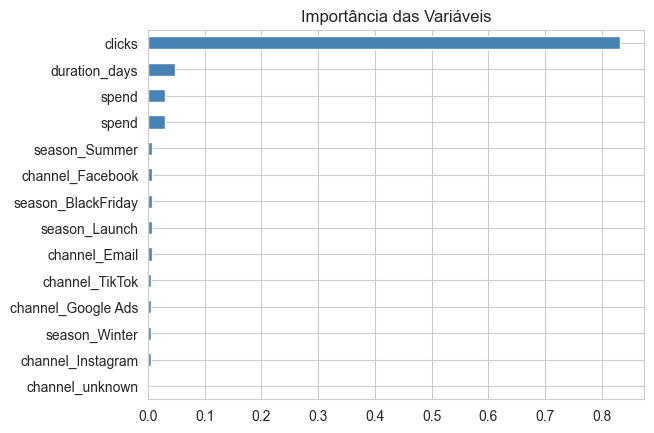

In [29]:
importance = pd.Series(modelo.feature_importances_,index = X.columns)
importance.sort_values().plot(kind='barh',color='steelblue')
plt.title('Importância das Variáveis')

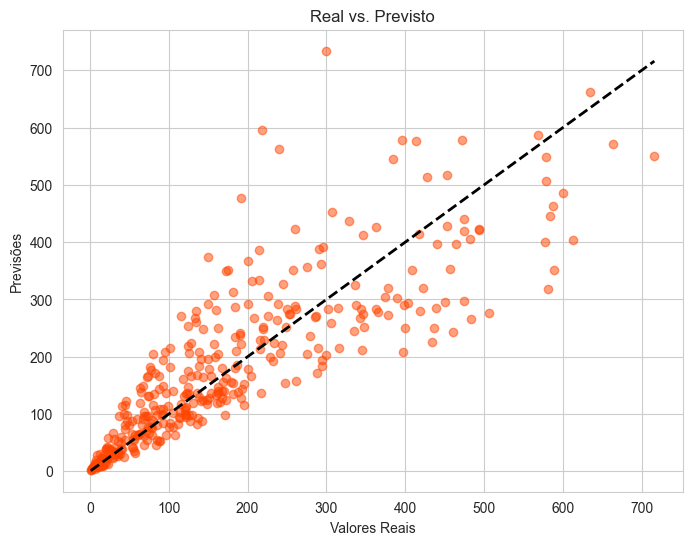

In [30]:
# --- GRÁFICO DE DISPERSÃO (REAL vs PREVISTO) ---
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, previsoes, alpha=0.5, color='orangered')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)

plt.title('Real vs. Previsto')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')

# SALVAR NO DISCO
plt.savefig('grafico_dispersao.png', dpi=300, bbox_inches='tight')
plt.show()